# Estratégia de cruzamento de Médias Móveis (*Moving Average Cross Strategy*)

Estudo realizado com o intuito de testar o comportamento de duas médias móveis simples (42 e 252 períodos), quando há o cruzamento das duas e, a partir disso, entrar comprado ou vendido no ativo.

Neste exemplo, temos uma base de dados de 10 anos (2010 até 2019), com 12 ativos. Para fins de estudo, usaremos um só ativo: o par EUR/USD. No entanto, a estratégia poderá ser replicada em quaisquer ativos.


---


*This study was carried out with the aim of testing the behavior of two simple moving averages (SMAs, 42 and 252 periods), when there is a crossing of the two SMAs and, from that, going long or short in the asset.*

*In this example, We have a 10-year database (2010 to 2019), with 12 assets. For study purposes, We'll use only one asset: the EUR/USD pair. However, the strategy can be replicated in any assets whatsoever.*

In [3]:
import pandas as pd
import numpy as np

In [4]:
rawdata = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/sma_dataset.csv',
index_col=0, parse_dates=True).dropna()

In [5]:
rawdata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL.O  2516 non-null   float64
 1   MSFT.O  2516 non-null   float64
 2   INTC.O  2516 non-null   float64
 3   AMZN.O  2516 non-null   float64
 4   GS.N    2516 non-null   float64
 5   SPY     2516 non-null   float64
 6   .SPX    2516 non-null   float64
 7   .VIX    2516 non-null   float64
 8   EUR=    2516 non-null   float64
 9   XAU=    2516 non-null   float64
 10  GDX     2516 non-null   float64
 11  GLD     2516 non-null   float64
dtypes: float64(12)
memory usage: 255.5 KB


In [6]:
# renaming the only column to 'price'
rawdata = pd.DataFrame(rawdata['EUR='])
rawdata.rename(columns={'EUR=': 'price'}, inplace=True)
rawdata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   2516 non-null   float64
dtypes: float64(1)
memory usage: 39.3 KB


In [7]:
# creating the SMAs columns
rawdata['SMA42'] = rawdata['price'].rolling(42).mean()
rawdata['SMA252'] = rawdata['price'].rolling(252).mean()
rawdata.tail()

,price,SMA42,SMA252
Date,,,
2019-12-24,1.1087,1.107698,1.119630
2019-12-26,1.1096,1.107740,1.119529
2019-12-27,1.1175,1.107924,1.119428
2019-12-30,1.1197,1.108131,1.119333
2019-12-31,1.1210,1.108279,1.119231


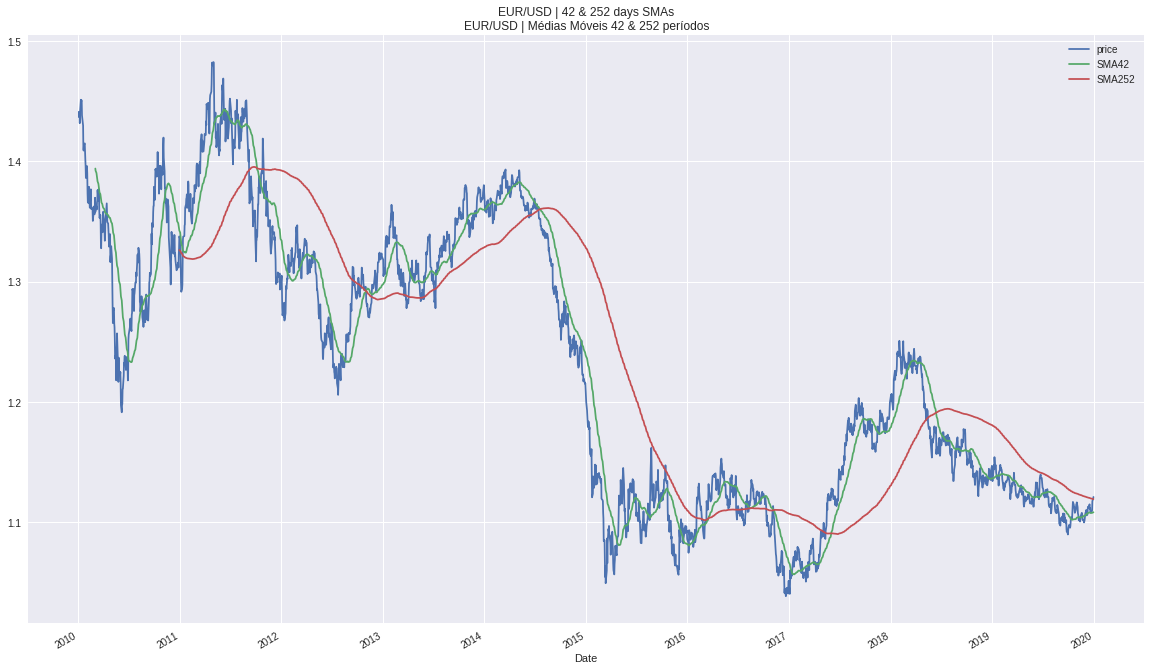

In [8]:
%matplotlib inline
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'sans-serif'
rawdata.plot(title='EUR/USD | 42 & 252 days SMAs\nEUR/USD | Médias Móveis 42 & 252 períodos',
             figsize=(20, 12));

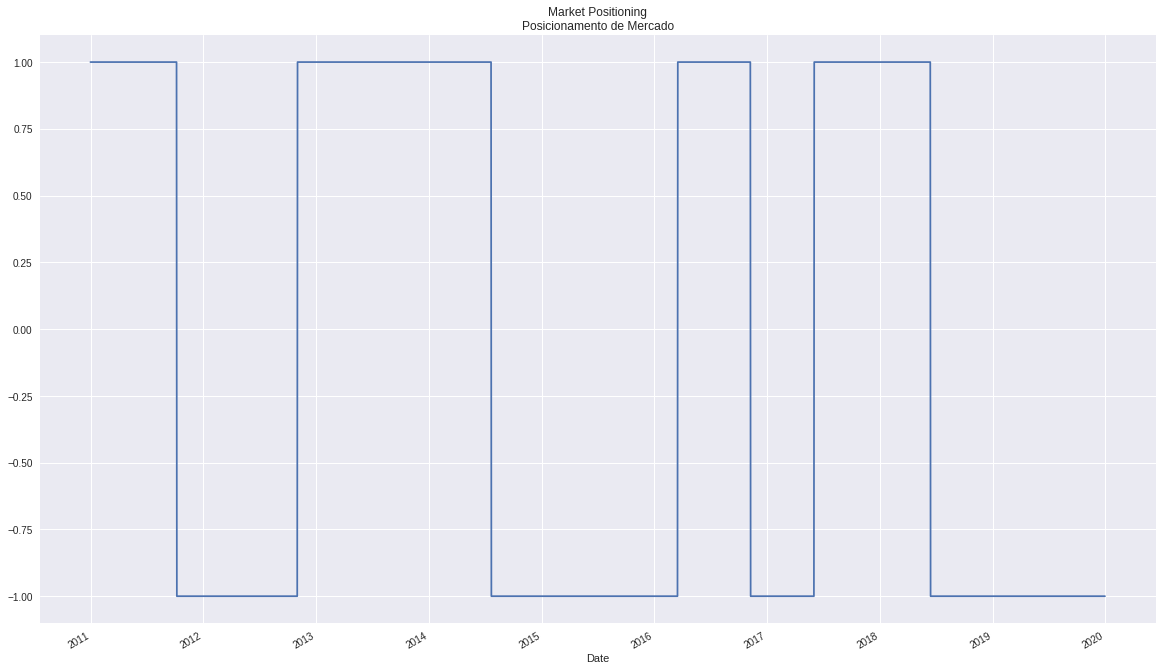

In [9]:
# generating positioning signals, which 1 stand for 'long position' and -1 for 'short position'
rawdata['position'] = np.where(rawdata['SMA42'] > rawdata['SMA252'],
1, -1)
rawdata.dropna(inplace=True)
rawdata['position'].plot(ylim=[-1.1, 1.1],
title='Market Positioning\nPosicionamento de Mercado',
figsize=(20, 12));

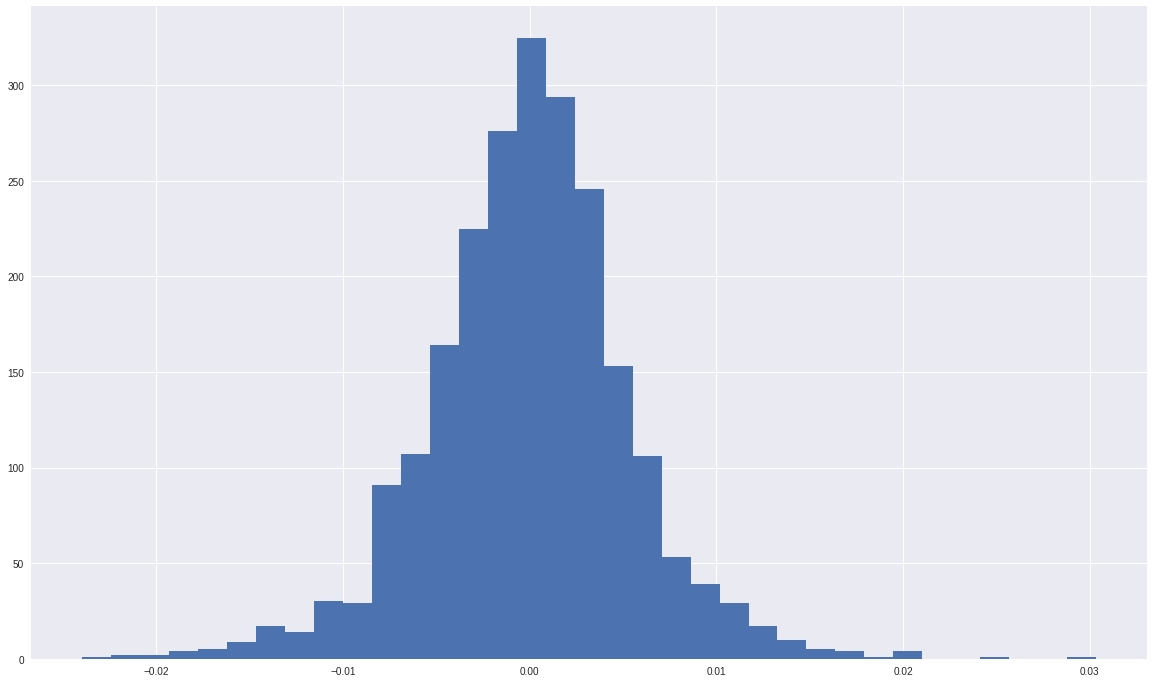

In [10]:
# plotting the log returns histogram
rawdata['returns'] = np.log(rawdata['price'] / rawdata['price'].shift(1))
rawdata['returns'].hist(bins=35, figsize=(20, 12));

In [11]:
# comparing and calculating the results from both SMA-based strategy and passive benchmark investment
rawdata['strategy'] = rawdata['position'].shift(1) * rawdata['returns']
rawdata[['returns', 'strategy']].sum()
rawdata[['returns', 'strategy']].sum().apply(np.exp)

returns     0.838006
strategy    1.288039
dtype: float64

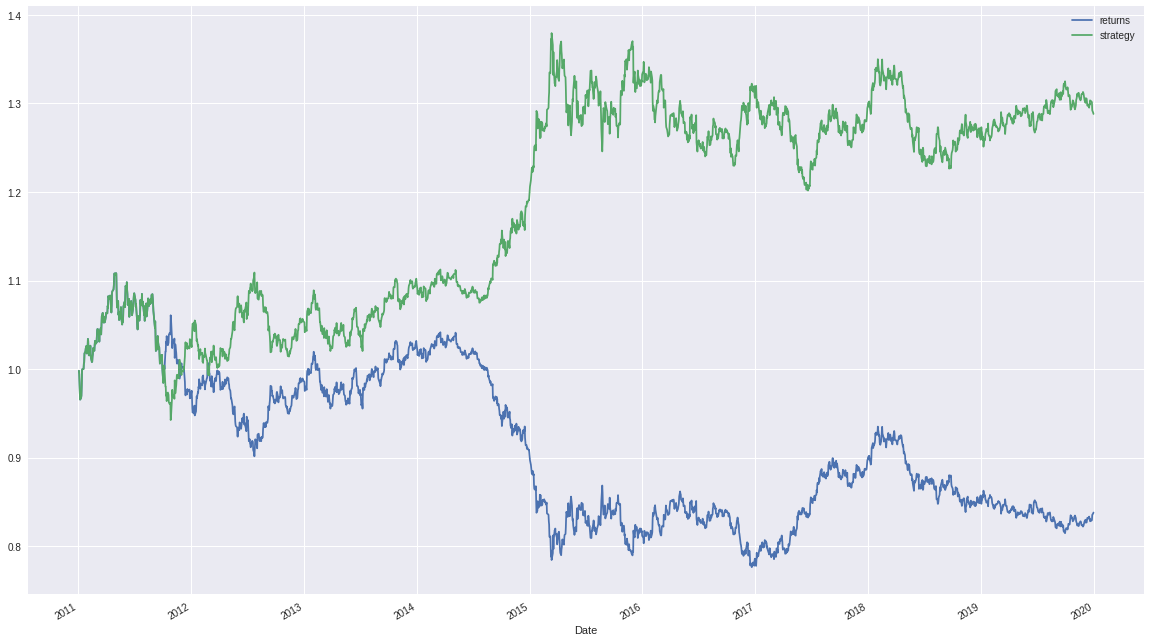

In [12]:
rawdata[['returns', 'strategy']].cumsum(
).apply(np.exp).plot(figsize=(20, 12));

In [13]:
# calculating annualized mean and standard deviation in log and regular space
rawdata[['returns', 'strategy']].mean() * 252

returns    -0.019671
strategy    0.028174
dtype: float64

In [14]:
np.exp(rawdata[['returns', 'strategy']].mean() * 252) - 1

returns    -0.019479
strategy    0.028575
dtype: float64

In [15]:
rawdata[['returns', 'strategy']].std() * 252 ** 0.5

returns     0.085414
strategy    0.085405
dtype: float64

In [96]:
(rawdata[['returns', 'strategy']].apply(np.exp) - 1).std() * 252 ** 0.5

returns     0.085405
strategy    0.085373
dtype: float64

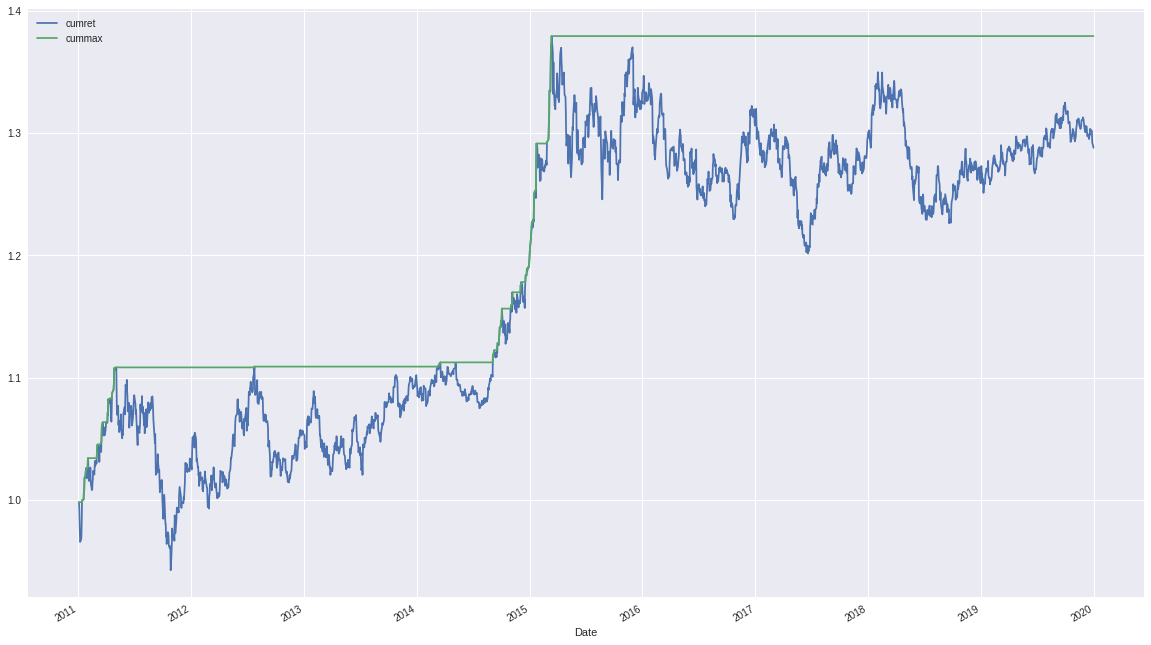

In [16]:
# creates two columns: 'cumret' (gross performance over time) and 'cummax' (maximum gross performance)
rawdata['cumret'] = rawdata['strategy'].cumsum().apply(np.exp)
rawdata['cummax'] = rawdata['cumret'].cummax()
rawdata[['cumret', 'cummax']].dropna().plot(figsize=(20, 12));

In [17]:
# calculating drawdown (max difference between 'cummax' and 'cumret')
drawdown = rawdata['cummax'] - rawdata['cumret']
drawdown.max()

0.17779367070195895

In [18]:
# calculating the longest drawdown period
temp = drawdown[drawdown == 0]
periods = (temp.index[1:].to_pydatetime() -
temp.index[:-1].to_pydatetime())
periods[12:15]

array([datetime.timedelta(days=1), datetime.timedelta(days=1),
       datetime.timedelta(days=10)], dtype=object)

In [19]:
periods.max()

datetime.timedelta(days=596)

In [20]:
# first, the module 'SMAVectorBacktester' was imported to our file. Then, we start the SMA-based strategy backtest, along with an example of optimization of the same SMA-based strategy
from scipy.optimize import brute


class SMAVectorBacktester(object):
    ''' Class for the vectorized backtesting of SMA-based trading strategies.
    Attributes
    ==========
    symbol: str
        RIC symbol with which to work with
    SMA1: int
        time window in days for shorter SMA
    SMA2: int
        time window in days for longer SMA
    start: str
        start date for data retrieval
    end: str
        end date for data retrieval
    Methods
    =======
    get_data:
        retrieves and prepares the base data set
    set_parameters:
        sets one or two new SMA parameters
    run_strategy:
        runs the backtest for the SMA-based strategy
    plot_results:
        plots the performance of the strategy compared to the symbol
    update_and_run:
        updates SMA parameters and returns the (negative) absolute performance
    optimize_parameters:
        implements a brute force optimizeation for the two SMA parameters
    '''

    def __init__(self, symbol, SMA42, SMA252, start, end):
        self.symbol = symbol
        self.SMA42 = SMA42
        self.SMA252 = SMA252
        self.start = start
        self.end = end
        self.results = None
        self.get_data()

    def get_data(self):
        ''' Retrieves and prepares the data.
        '''
        rawdata = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/sma_dataset.csv',
                          index_col=0, parse_dates=True).dropna()
        rawdata = pd.DataFrame(rawdata[self.symbol])
        rawdata = rawdata.loc[self.start:self.end]
        rawdata.rename(columns={self.symbol: 'price'}, inplace=True)
        rawdata['return'] = np.log(rawdata / rawdata.shift(1))
        rawdata['SMA42'] = rawdata['price'].rolling(self.SMA42).mean()
        rawdata['SMA252'] = rawdata['price'].rolling(self.SMA252).mean()
        self.data = rawdata

    def set_parameters(self, SMA42=None, SMA252=None):
        ''' Updates SMA parameters and resp. time series.
        '''
        if SMA42 is not None:
            self.SMA42 = SMA42
            self.data['SMA42'] = self.data['price'].rolling(
                self.SMA42).mean()
        if SMA252 is not None:
            self.SMA252 = SMA252
            self.data['SMA252'] = self.data['price'].rolling(self.SMA252).mean()

    def run_strategy(self):
        ''' Backtests the trading strategy.
        '''
        data = self.data.copy().dropna()
        data['position'] = np.where(data['SMA42'] > data['SMA252'], 1, -1)
        data['strategy'] = data['position'].shift(1) * data['return']
        data.dropna(inplace=True)
        data['creturns'] = data['return'].cumsum().apply(np.exp)
        data['cstrategy'] = data['strategy'].cumsum().apply(np.exp)
        self.results = data
        # gross performance of the strategy
        aperf = data['cstrategy'].iloc[-1]
        # out-/underperformance of strategy
        operf = aperf - data['creturns'].iloc[-1]
        return round(aperf, 2), round(operf, 2)

    def plot_results(self):
        ''' Plots the cumulative performance of the trading strategy
        compared to the symbol.
        '''
        if self.results is None:
            print('No results to plot yet. Run a strategy.')
        title = '%s | SMA42=%d, SMA252=%d' % (self.symbol,
                                               self.SMA42, self.SMA252)
        self.results[['creturns', 'cstrategy']].plot(title=title,
                                                     figsize=(20, 12))

    def update_and_run(self, SMA):
        ''' Updates SMA parameters and returns negative absolute performance
        (for minimazation algorithm).
        Parameters
        ==========
        SMA: tuple
            SMA parameter tuple
        '''
        self.set_parameters(int(SMA[0]), int(SMA[1]))
        return -self.run_strategy()[0]

    def optimize_parameters(self, SMA42_range, SMA252_range):
        ''' Finds global maximum given the SMA parameter ranges.
        Parameters
        ==========
        SMA42_range, SMA252_range: tuple
            tuples of the form (start, end, step size)
        '''
        opt = brute(self.update_and_run, (SMA42_range, SMA252_range), finish=None)
        return opt, -self.update_and_run(opt)


if __name__ == '__main__':
    smabt = SMAVectorBacktester('EUR=', 42, 252,
                                '2010-1-1', '2020-12-31')
    print(smabt.run_strategy())
    smabt.set_parameters(SMA42=20, SMA252=100)
    print(smabt.run_strategy())
    print(smabt.optimize_parameters((30, 56, 4), (200, 300, 4)))

(1.29, 0.45)
(0.97, 0.05)
(array([ 50., 236.]), 1.49)


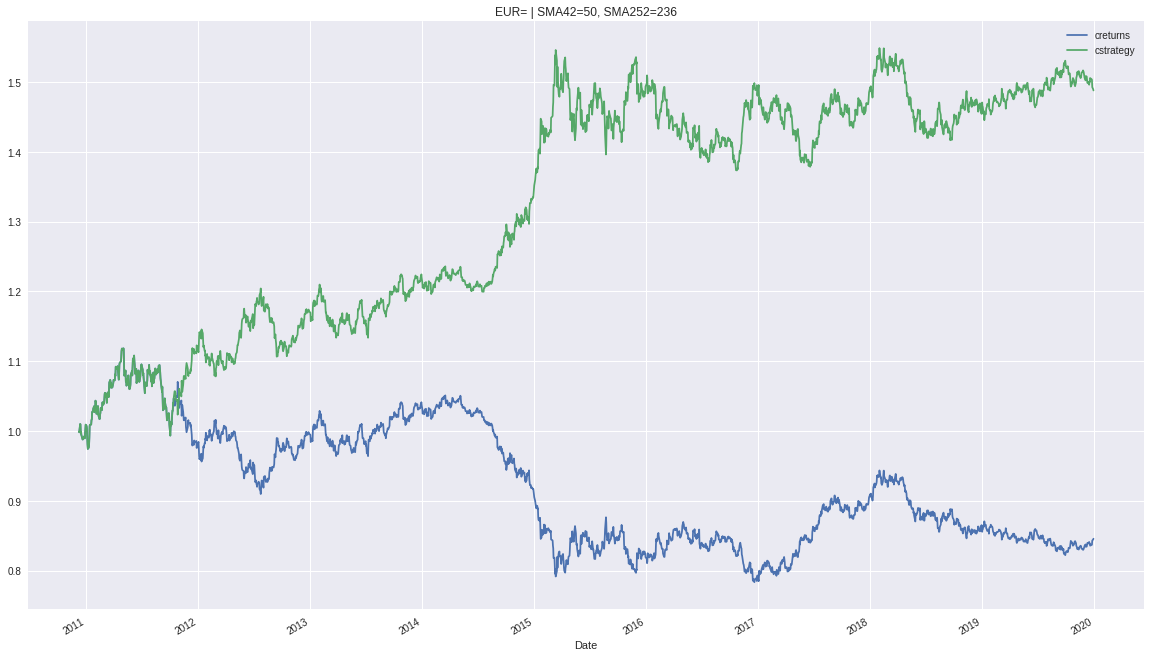

In [21]:
smabt.plot_results()

## Resultado (Results)

O primeiro modelo usado (médias móveis simples, de 42 e 252 períodos) teve um resultado de 1.2880 (ou 128.8%) no período testado. Já o modelo com parâmetros otimizados (médias móveis simples, de 50 e 236 períodos) apresentou uma performance de 1.49 (ou 149%). O modelo otimizado, desconsiderando taxas e outros custos, teve uma performance 15.68% acima do modelo inicial.

---

*The first model used (SMAs, 42 and 252 periods) had a result of 1.2880 (or 128.8%) in the tested period. The model with optimized parameters (SMAs, of 50 and 236 periods) presented a performance of 1.49 (or 149%). The optimized model, excluding fees and other costs, performed 15.68% higher than the initial model.*